### 1. Data Exploration & Pre-Processing

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!unzip /content/"SMU DSA Society x Maersk Case Competition 2023 Datasets.zip" -d dataset

Saving SMU DSA Society x Maersk Case Competition 2023 Datasets.zip to SMU DSA Society x Maersk Case Competition 2023 Datasets.zip
User uploaded file "SMU DSA Society x Maersk Case Competition 2023 Datasets.zip" with length 3066085 bytes
Archive:  /content/SMU DSA Society x Maersk Case Competition 2023 Datasets.zip
  inflating: dataset/Airline Passenger Satisfaction.csv  
  inflating: dataset/Voice of Customer.csv  


In [2]:
import pandas as pd
import numpy as np

csv_file_path = '/content/dataset/Airline Passenger Satisfaction.csv'
airline = pd.read_csv(csv_file_path)
# set index
airline = airline.set_index("id")
airline = airline.iloc[:,1:]

# convert columns to category data type for memory efficiency
airline_categorical = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
airline[airline_categorical] = airline[airline_categorical].astype('category')

# age segmentation
age_bin_edges = [-1, 17, 35, 60, 100]
age_bin_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
airline['Age Group'] = pd.cut(airline['Age'], bins=age_bin_edges, labels=age_bin_labels, right=False)

# distance segmentation
distance_bin_edges = [-1, 1499, 3500, 9000]
distance_bin_labels = ['Short-Haul', 'Medium-Haul', 'Long-Haul']
airline['Flight Length'] = pd.cut(airline['Flight Distance'], bins=distance_bin_edges, labels=distance_bin_labels, right=False)

# Departure/Arrival Delay
airline['Departure/Arrival delay'] = airline['Arrival Delay in Minutes'] + airline['Departure Delay in Minutes']

# Satisfaction
satisfaction_bin_edges = [-1, 4, 6, 8, 11]
satisfaction_bin_labels = ['Highly Dissatisfied', 'Dissatisfied', 'Neutral', 'Highly Satisfied']
airline['Satisfaction'] = pd.cut(airline['satisfaction score'], bins=satisfaction_bin_edges, labels=satisfaction_bin_labels, right=False)

# drop columns
airline.drop(columns=['Age','Flight Distance','Arrival Delay in Minutes','Departure Delay in Minutes', 'satisfaction'], inplace=True)

# Create a dictionary to map the current column names to their capitalized versions
capitalized_column_names = {col: col.capitalize() for col in airline.columns}

# Rename the columns using the dictionary
airline.rename(columns=capitalized_column_names, inplace=True)

# Create a dictionary to map the old values to the new values
replace_customertype = {"Loyal Customer": "Loyal", "disloyal Customer": "Disloyal"}
replace_typeoftravel = {"Personal Travel": "Personal", "Business travel":"Business"}

# Use the replace() method to change the values in the "Customer Type" column
airline["Customer type"] = airline["Customer type"].replace(replace_customertype)
airline["Type of travel"] = airline["Type of travel"].replace(replace_typeoftravel)

# Specify the desired order of columns
column_order = ['Gender', 'Age group', 'Type of travel', 'Class', 'Flight length', 'Departure/arrival delay',
                   'Customer type', 'Satisfaction score', 'Satisfaction']

# Reorder the columns in the DataFrame
airline_arranged = airline[column_order + [col for col in airline.columns if col not in column_order]]
airline_arranged = airline_arranged.sort_values('id', ascending=True)

airline_arranged = airline_arranged.drop('Satisfaction', axis=1)

#Dataset for Random Forest
airline_arranged_new = airline_arranged

### 2. Logistic Regression

2.1 Numerical and Cateogorical Features

In [3]:
# Separate numerical and categorical features
numerical_features = ['Inflight wifi service',
                      'Departure/arrival time convenient',
                      'Ease of online booking',
                      'Gate location',
                      'Food and drink',
                      'Online boarding',
                      'Seat comfort',
                      'Inflight entertainment',
                      'On-board service',
                      'Leg room service',
                      'Baggage handling',
                      'Checkin service',
                      'Inflight service',
                      'Cleanliness',
                      'Departure/arrival delay',
                      'Satisfaction score']

categorical_features = ['Gender',
                        'Age group',
                        'Type of travel',
                        'Class',
                        'Flight length']

target = ['Customer type']

2.2 Column Rescaling and Encoding of Categorical Features

In [4]:
def scale_column(df, col_name, new_min, new_max):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    df_scaled = df.copy()
    df_scaled[col_name] = (df_scaled[col_name] - col_min) / (col_max - col_min) * (new_max - new_min) + new_min
    return df_scaled

def scale_column_reverse(df, col_name, new_min, new_max):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    df_scaled = df.copy()
    df_scaled[col_name] = (col_max - df_scaled[col_name]) / (col_max - col_min) * (new_max - new_min) + new_min
    return df_scaled

airline_arranged = scale_column_reverse(airline_arranged, 'Departure/arrival delay', 0, 1)
airline_arranged = scale_column(airline_arranged, numerical_features, 0, 1)

# Convert 'Customer Type' to binary target variable (0: Not Loyal, 1: Loyal)
airline_arranged['Loyal'] = (airline_arranged['Customer type'] == 'Loyal').astype(int)

airline_encode = pd.get_dummies(airline_arranged, columns=categorical_features, drop_first=True)

# Separate features and target
airline_encode = airline_encode.drop(target, axis=1)
X = airline_encode.drop('Loyal', axis=1)
y = airline_encode['Loyal']

2.3 Running the Regression Model

Accuracy: 0.9006005543578688
Precision: 0.9286306289713602
Recall: 0.9513207547169812
F1-score: 0.9398387622908804


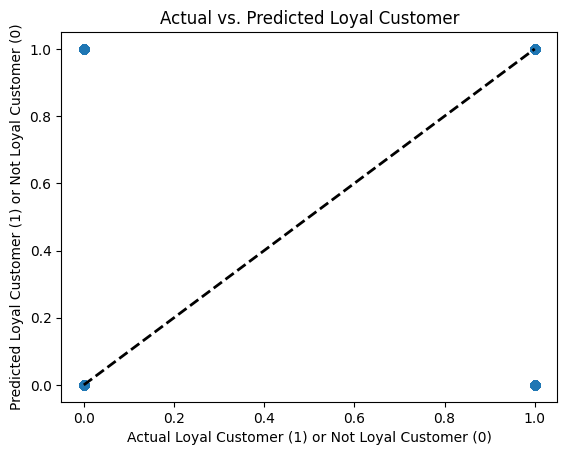

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Create a DataFrame to hold the actual and predicted values
actual_vs_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot the scatter plot of actual vs. predicted
plt.scatter(actual_vs_pred_df['Actual'], actual_vs_pred_df['Predicted'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Loyal Customer (1) or Not Loyal Customer (0)')
plt.ylabel('Predicted Loyal Customer (1) or Not Loyal Customer (0)')
plt.title('Actual vs. Predicted Values of Customer Loyalty')
plt.show()

2.4 Finding Feature Importance

                              Feature  Coefficient  Abs_Coefficient
20            Type of travel_Personal     6.164003         6.164003
24            Flight length_Long-Haul     4.350740         4.350740
1                  Satisfaction score     3.632568         3.632568
9              Inflight entertainment     2.756662         2.756662
7                     Online boarding     2.511966         2.511966
23          Flight length_Medium-Haul     2.186830         2.186830
15                        Cleanliness    -2.145176         2.145176
2               Inflight wifi service    -2.091844         2.091844
19                   Age group_Senior     1.961861         1.961861
0             Departure/arrival delay    -1.753324         1.753324
14                   Inflight service    -1.524779         1.524779
3   Departure/arrival time convenient     1.472790         1.472790
18                    Age group_Adult     1.322952         1.322952
13                    Checkin service    -1.3157

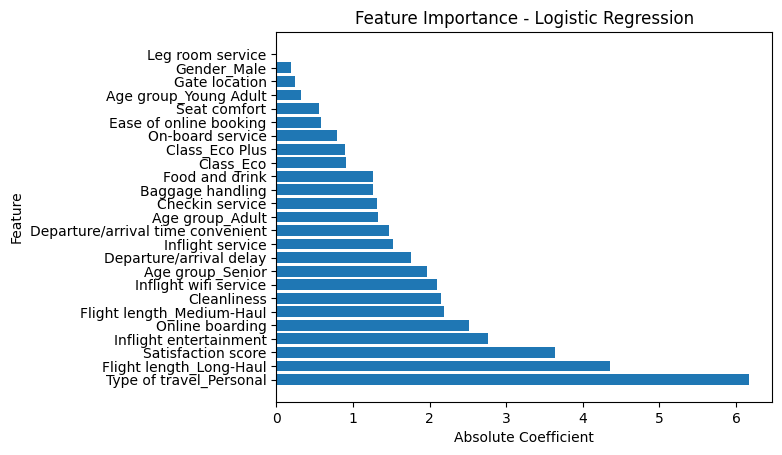

In [6]:
# Access the coefficients
coefficients = logreg_model.coef_[0]

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values to get the most important features
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print or plot the feature importance
print(feature_importance_df)

# Optionally, you can plot the feature importance
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.show()

### 3. Random Forest

3.1 Encoding Categorical Variables

In [7]:
# #Create a new dataframe from airline_arranged
# airline_arranged_new = airline_arranged

# Create a dictionary to map "disloyal" to 1 and "loyal" to 0
customer_type_mapping = {"Disloyal": 1, "Loyal": 0}

# Use the map() method to change the values in the "Customer type" column
airline_arranged_new["Customer type"] = airline_arranged_new["Customer type"].map(customer_type_mapping)


In [8]:
# Convert categorical variables to numerical values using dummy encoding
airline_arranged_new = pd.get_dummies(airline_arranged_new, columns=['Gender',
                                                            'Age group',
                                                            'Type of travel',
                                                            'Class',
                                                            'Flight length'], drop_first=True)

#separate numerical and categorical features
num_features = ['Inflight wifi service',
                      'Departure/arrival time convenient',
                      'Ease of online booking',
                      'Gate location',
                      'Food and drink',
                      'Online boarding',
                      'Seat comfort',
                      'Inflight entertainment',
                      'On-board service',
                      'Leg room service',
                      'Baggage handling',
                      'Checkin service',
                      'Inflight service',
                      'Cleanliness',
                      'Departure/arrival delay',
                      'Satisfaction score']

target_1 = ['Customer type']

def scale_column(df, col_name, new_min, new_max):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    df_scaled = df.copy()
    df_scaled[col_name] = (df_scaled[col_name] - col_min) / (col_max - col_min) * (new_max - new_min) + new_min
    return df_scaled

def scale_column_reverse(df, col_name, new_min, new_max):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    df_scaled = df.copy()
    df_scaled[col_name] = (col_max - df_scaled[col_name]) / (col_max - col_min) * (new_max - new_min) + new_min
    return df_scaled

airline_arranged_new = scale_column_reverse(airline_arranged_new, 'Departure/arrival delay', 0, 1)
airline_arranged_new = scale_column(airline_arranged_new, num_features, 0, 1)

3.2 Splitting X and y values

In [9]:

#Determine the categorical variables
X_cat_new = airline_arranged_new.drop(target_1 + num_features, axis=1)
X_cat_loyal = X_cat_new.values
X_cat_new.head()

X_num_loyal = airline_arranged_new[num_features].values
y_loyal = airline_arranged_new[target_1].values

X_num_cat_loyal = np.concatenate((X_num_loyal, X_cat_loyal), axis=1) #concatenate numerical and categorical features

print(X_num_cat_loyal)

[[0.6 0.6 0.6 ... 0.  0.  0. ]
 [0.4 0.4 0.4 ... 0.  0.  0. ]
 [0.8 0.8 0.8 ... 0.  0.  0. ]
 ...
 [0.4 1.  0.4 ... 1.  0.  0. ]
 [1.  0.8 0.8 ... 1.  0.  0. ]
 [0.6 0.2 0.6 ... 1.  0.  0. ]]


3.3 Running the Random Forest

In [14]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_num_cat_loyal, y_loyal, test_size=0.2, random_state=1)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluate the model
y_pred_rf = rf_model.predict (X_test_rf)

# Calculate accuracy, precision, recall, and F1-score
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
precision_rf = precision_score(y_test_rf, y_pred_rf)
recall_rf = recall_score (y_test_rf, y_pred_rf)
f1_rf = f1_score (y_test_rf, y_pred_rf)

print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)

<ipython-input-14-771effa3df24>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_rf, y_train_rf)


Accuracy: 0.9872189713581768
Precision: 0.9809811973200778
Recall: 0.9489859920551955
F1-score: 0.9647183846971308


3.4 Finding Feature Importance

In [11]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_rf_df = pd.DataFrame({'Feature': airline_arranged_new.drop('Customer type', axis=1).columns, 'Importance': feature_importances})
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_rf_df)

Feature Importances:
                              Feature  Importance
20            Type of travel_Personal    0.189063
1                  Satisfaction score    0.086527
15                        Cleanliness    0.064826
17              Age group_Young Adult    0.064806
2               Inflight wifi service    0.062575
5                       Gate location    0.053718
3   Departure/arrival time convenient    0.052812
0             Departure/arrival delay    0.041155
21                          Class_Eco    0.040042
23          Flight length_Medium-Haul    0.039006
12                   Baggage handling    0.034480
7                     Online boarding    0.034476
10                   On-board service    0.031776
6                      Food and drink    0.030031
13                    Checkin service    0.023813
18                    Age group_Adult    0.022403
8                        Seat comfort    0.021032
11                   Leg room service    0.020531
4              Ease of online

3.5 Plotting the forest

[Text(0.5, 0.9, 'x[17] <= 0.5\ngini = 0.299\nsamples = 103904\nvalue = [84907, 18997]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.179\nsamples = 71282\nvalue = [64215, 7067]'),
 Text(0.6666666666666666, 0.7, 'x[20] <= 0.5\ngini = 0.464\nsamples = 32622\nvalue = [20692, 11930]'),
 Text(0.5, 0.5, 'x[21] <= 0.5\ngini = 0.5\nsamples = 23633\nvalue = [11749, 11884]'),
 Text(0.3333333333333333, 0.3, 'x[1] <= 0.1\ngini = 0.428\nsamples = 14574\nvalue = [10049, 4525]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.248\nsamples = 1435\nvalue = [208, 1227]'),
 Text(0.5, 0.1, 'gini = 0.376\nsamples = 13139\nvalue = [9841, 3298]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.305\nsamples = 9059\nvalue = [1700, 7359]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.01\nsamples = 8989\nvalue = [8943, 46]')]

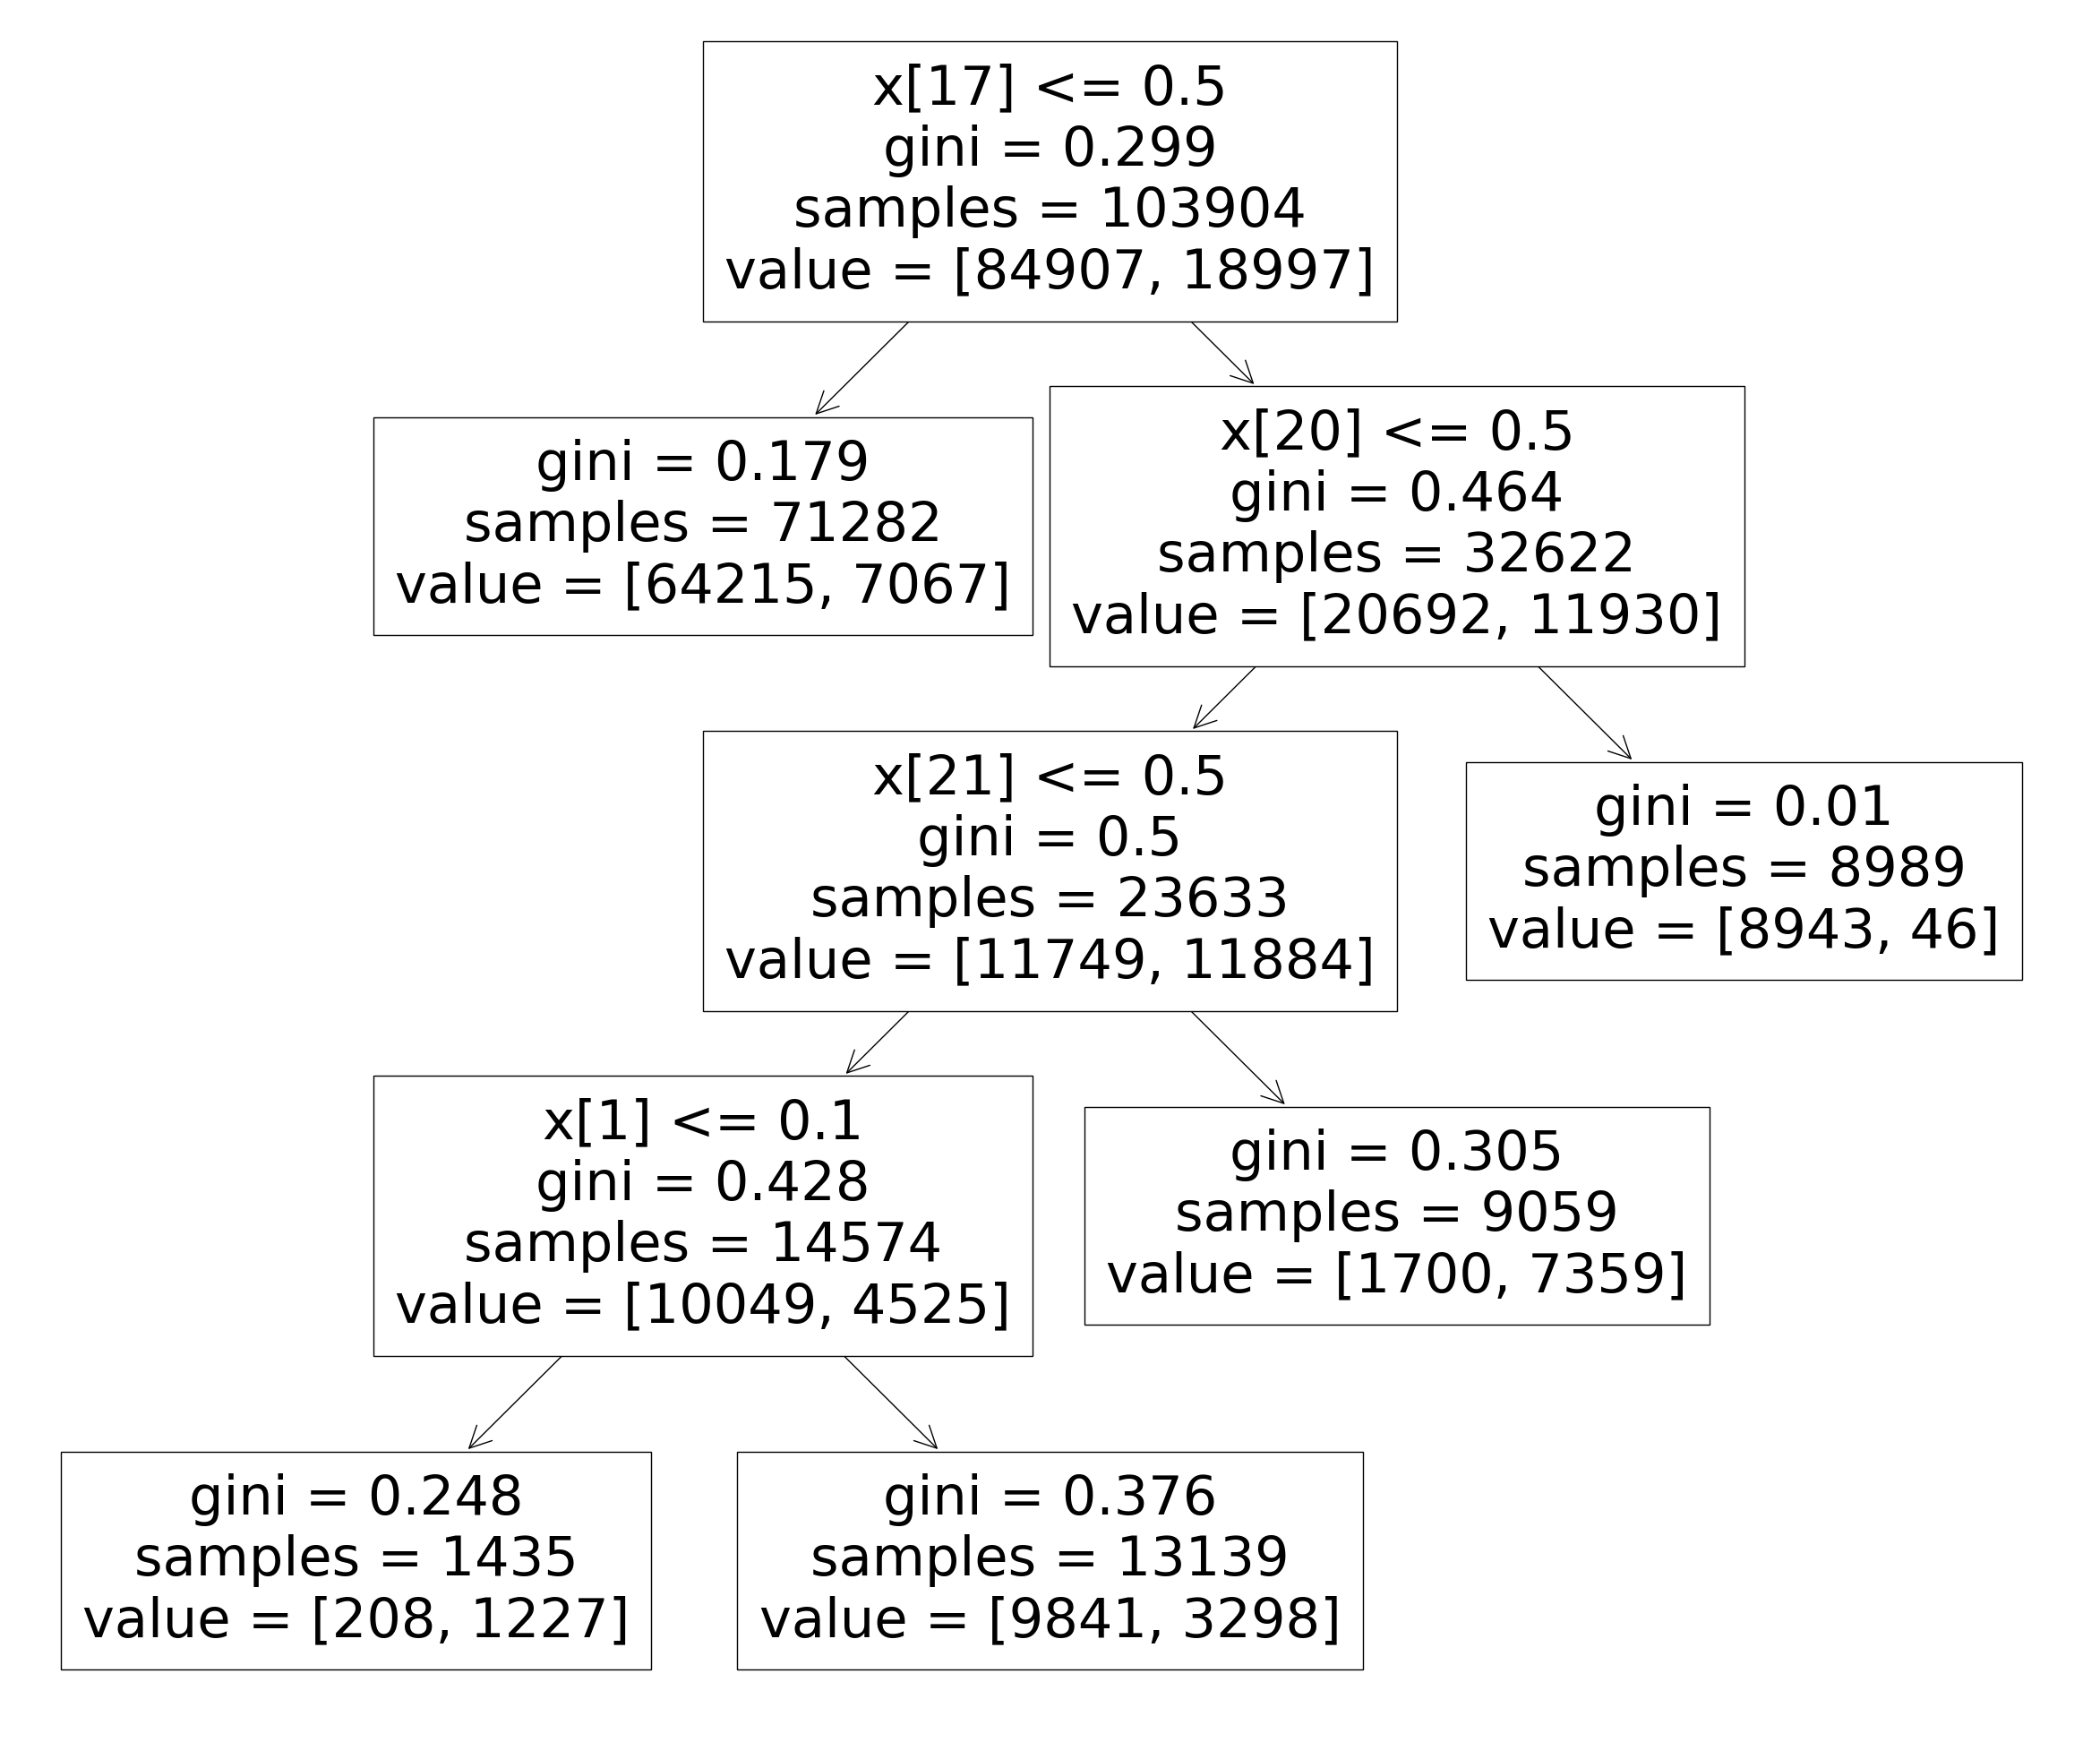

In [12]:
#Create Random Forest
from sklearn import tree
from sklearn.tree import export_text
fig = plt.figure(figsize=(30,25))
model_classifier = tree.DecisionTreeClassifier(max_leaf_nodes=5) #Using Square root of 24 (total number of features)
model_res = model_classifier.fit(X_train_rf,y_train_rf)
tree.plot_tree(model_res)


3.6 Evaluating the Model

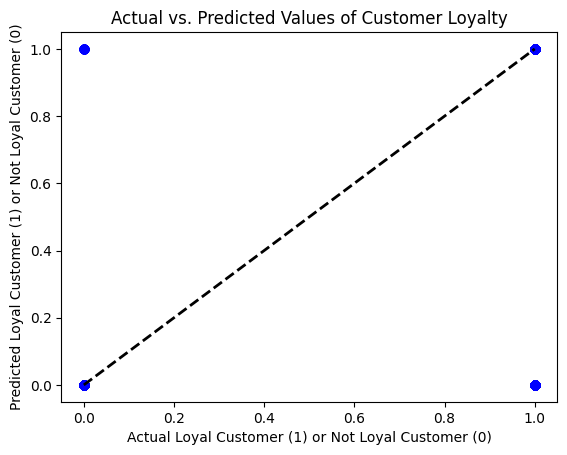

In [19]:
#Model Evaluation
plt.scatter(y_test_rf, y_pred_rf, color='b', alpha=0.5)
plt.plot([min(y_test_rf), max(y_test_rf)], [min(y_test_rf), max(y_test_rf)], 'k--', lw=2)
plt.xlabel('Actual Loyal Customer (1) or Not Loyal Customer (0)')
plt.ylabel('Predicted Loyal Customer (1) or Not Loyal Customer (0)')
plt.title('Actual vs. Predicted Values of Customer Loyalty')
plt.show()